In [1]:
import os
import numpy as np
import tensorflow.keras as keras
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import pickle
from tqdm.notebook import tqdm
import pandas as pd
import seaborn as sns
from src.models.train_model import MonteCarloDropout, MCLSTM

In [2]:
model_name = r"merged-ce-mc.h5"
model_path =  r"C:\Users\Noaja\Downloads\msci_project\tth-ML-project\models\wandb_models"
load_path = r"C:\Users\Noaja\Downloads\msci_project\tth-ML-project\data\processed"

model_path = os.path.join(model_path, model_name)

model = keras.models.load_model(model_path, custom_objects={"MCLSTM": MCLSTM, "MonteCarloDropout": MonteCarloDropout})

with open(os.path.join(load_path, "processed_data.pickle"), "rb") as handle:
    combined_data = pickle.load(handle)

y_test = combined_data['y_test']
y_train = combined_data['y_train']

event_X_train = combined_data['event_X_train']
object_X_train = combined_data['object_X_train']

event_X_test = combined_data['event_X_test']
object_X_test = combined_data['object_X_test']

In [3]:
from src.features.build_features import scale_event_data, scale_object_data

event_X_train, event_X_test = scale_event_data(event_X_train, event_X_test)
object_X_train, object_X_test = scale_object_data(object_X_train, object_X_test)

In [4]:
def add_noise(data, percentage):
    varied_data = data.copy()
    for col in range(data.shape[1]):
        mean = np.mean(data[:, col])
        std = np.std(data[:, col]) * percentage
        noise = np.random.normal(0, std, data[:, col].shape)
        varied_data[:, col] += noise

    return varied_data


def get_test_predictions(n_bins, type, max_percent=20, scale_range=0.2):
    x_values = []
    scores = []
    if n_bins % 2 == 0: n_bins += 1
    
    for i in range(1, n_bins+1):
        percentage = np.round((i / n_bins) * (max_percent/100), 4)
        scale_factor = (1 - scale_range) + (2 * scale_range * ((i-1) / (n_bins-1)))
        scale_factor = np.round(scale_factor, 4)

        varied_event_data = event_X_test.copy()
        varied_object_data = object_X_test.copy()

        if type == "noise":
            varied_event_data[:] = add_noise(event_X_test.values, percentage)
            varied_object_data = add_noise(object_X_test, percentage)
            x_values.append(percentage)

        elif type == "scale":
            varied_event_data['HT'] *= scale_factor
            x_values.append(scale_factor)

        preds = model.predict([varied_event_data, varied_object_data]).ravel()
        auc = roc_auc_score(y_test, preds)
        scores.append(auc)
    
    return (x_values, scores)

In [5]:
num_samples = 10
n_bins = 9
max_percent = 20
scale_range = 0.2

def noise_impact(num_samples, n_bins, max_percent):
    robust_df = pd.DataFrame(columns=['noise percentage', 'AUC'])
    for _ in tqdm(range(num_samples)):
        percentages, scores = get_test_predictions(n_bins, "noise", max_percent=max_percent)
        for percentage, score in zip(percentages, scores):
            robust_df = robust_df.append({'noise percentage': percentage*100, 'AUC': score}, ignore_index=True)

    baseline_preds = model.predict([event_X_test, object_X_test]).ravel()
    baseline_auc = roc_auc_score(y_test, baseline_preds)
    robust_df['Δ ROC AUC'] = robust_df['AUC'] - baseline_auc

    return robust_df


def scale_impact(num_samples, n_bins, scale_range):
    robust_df = pd.DataFrame(columns=['HT scale factor', 'AUC'])
    for _ in tqdm(range(num_samples)):
        factors, scores = get_test_predictions(n_bins, "scale", scale_range=scale_range)
        for factor, score in zip(factors, scores):
            robust_df = robust_df.append({'HT scale factor': factor, 'AUC': score}, ignore_index=True)

    return robust_df

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\Noaja\AppData\Local\Temp\ipykernel_6908\1621571510.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  robust_df = robust_df.append({'noise percentage': percentage*100, 'AUC': score}, ignore_index=True)
C:\Users\Noaja\AppData\Local\Temp\ipykernel_6908\1621571510.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  robust_df = robust_df.append({'noise percentage': percentage*100, 'AUC': score}, ignore_index=True)
C:\Users\Noaja\AppData\Local\Temp\ipykernel_6908\1621571510.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  robust_df = robust_df.append({'noise percentage': percentage*100, 'AUC': score}, ignore_index=True)
C:\Users\Noaja\AppData\Local\Temp\ipykernel_6908\1621571510.py:11: FutureWarning: The frame.ap

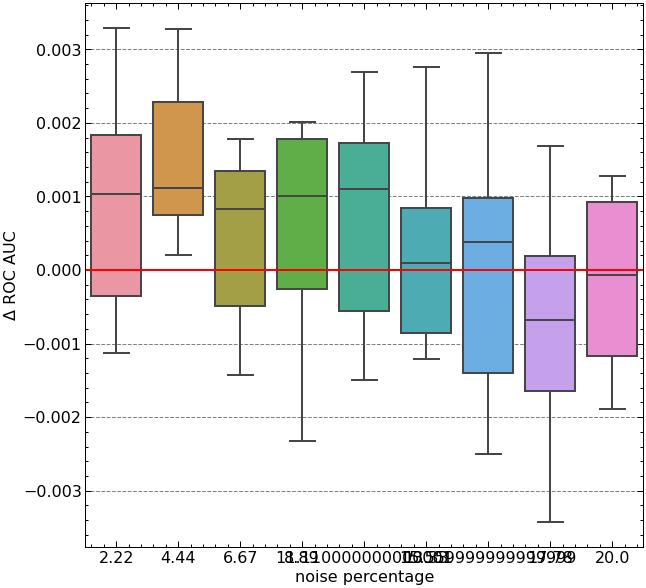

In [7]:
robust_df = noise_impact(num_samples, n_bins, max_percent)

with plt.style.context(['science', 'grid', 'notebook', 'high-contrast']):
    plt.figure(figsize=(10, 10))
    sns.boxplot(x="noise percentage", y="Δ ROC AUC", data=robust_df)
    plt.axhline(y=0.0, color='r', linestyle='-')
    plt.show()

In [ ]:
robust_df = scale_impact(num_samples=10, n_bins=9, scale_range=scale_range)

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\Noaja\AppData\Local\Temp\ipykernel_3260\902590205.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  robust_df = robust_df.append({'scale factor': factor, 'AUC': score}, ignore_index=True)
C:\Users\Noaja\AppData\Local\Temp\ipykernel_3260\902590205.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  robust_df = robust_df.append({'scale factor': factor, 'AUC': score}, ignore_index=True)
C:\Users\Noaja\AppData\Local\Temp\ipykernel_3260\902590205.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  robust_df = robust_df.append({'scale factor': factor, 'AUC': score}, ignore_index=True)
C:\Users\Noaja\AppData\Local\Temp\ipykernel_3260\902590205.py:25: FutureWarning: The frame.append method is deprecated and will be re

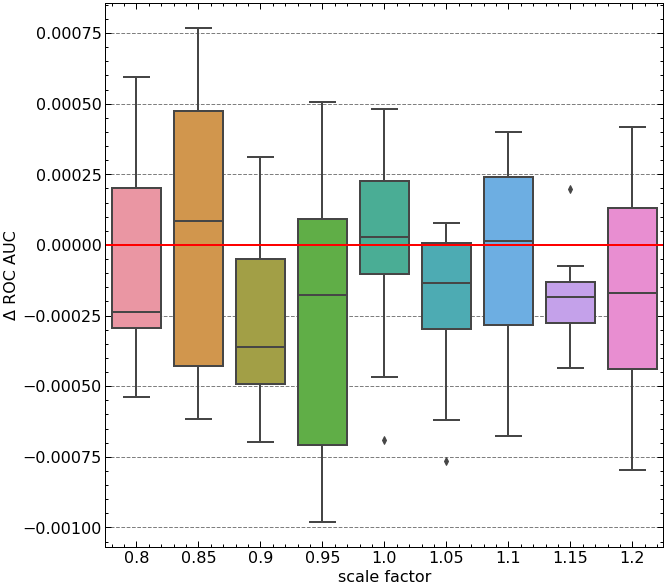

In [ ]:
robust_df['Δ ROC AUC'] = robust_df['AUC'] - np.mean(robust_df.loc[robust_df['HT scale factor'] == 1, 'AUC'])

with plt.style.context(['science', 'grid', 'notebook', 'high-contrast']):
    plt.figure(figsize=(10, 10))
    sns.boxplot(x="HT scale factor", y="Δ ROC AUC", data=robust_df)
    plt.axhline(y=0.0, color='r', linestyle='-')
    plt.show()